## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.



    Load your data into Tetrad, generating a Dataset object.
    Feed your data into a Search Algorithm.
    Choose search settings/assumptions that make sense, given how your data were collected.
    The output will be an equivalence class of graphs. Choose one plausible DAG from the output equivalence class.
    Choose a parametric model that makes sense for your data.
    Use your dataset to learn the parameters of the instantiated model.


# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.dirichlet([1,1])

array([0.5352784, 0.4647216])

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s

import scipy.stats as ss


def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 50000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
   
    return pd.DataFrame({'a' : a,'b' : b})


def gen_data(SIZE=50000, mean = 0, var = 1):
    p_z = 0.5
    p_y_z = [0.9, 0.1]
    p_x_y = [0.2, 0.8]
    Z = np.random.binomial(n=1, p=p_z, size=SIZE)
    
    noise = np.random.normal(mean, var, SIZE)
    for i, val in enumerate(noise):
        if val > 1:
            Z[i] = int(1 - Z[i])

    p_y = np.choose(Z, p_y_z)
    

    Y = np.random.binomial(n=1, p=p_y, size=SIZE)
    noise = np.random.normal(mean, var, SIZE)
    
    for i, val in enumerate(noise):
        if val > 1:
            Y[i] = int(1 - Y[i])
    
    p_x = np.choose(Z, p_x_y)
    #p_x = np.choose(Y+2*Z, p_x_y)
    X = np.random.binomial(n=1, p=p_x, size=SIZE)
    noise = np.random.normal(mean, var, SIZE)
    
    for i, val in enumerate(noise):
        if val > 1:
            X[i] = int(1 - X[i])

    return pd.DataFrame({"x":X, "y":Y, "z":Z})

def gen_data(SIZE=50000, mean = 0, var = 0):
    p_z = 0.5
    Z = np.random.binomial(n=3, p=p_z, size=SIZE)
    

    Y = np.random.binomial(n=Z + mean, p=0.5 + var, size=SIZE)
    X = np.random.binomial(n=Y + mean, p=0.5 + var, size=SIZE)
    
    return pd.DataFrame({"x":X, "y":Y, "z":Z})

def gen_data(SIZE=50000, mean = 0, var = 1):
    a = discrete_gauss(mean - var, mean + var, samples=SIZE,std=var)  
    b = discrete_gauss(mean - var, mean + var, samples=SIZE,std=var)  
    c = discrete_gauss(mean - var, mean + var, samples=SIZE,std=var)  
    d = discrete_gauss(mean - var, mean + var, samples=SIZE,std=var)  
    e = discrete_gauss(mean - var, mean + var, samples=SIZE, std=var)  
    f= a + b + c + d + e + discrete_gauss(mean - var, mean + var,samples=SIZE, std=var)  
    g = f + discrete_gauss(mean - var, mean + var, samples=SIZE, std=var)  
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})
    
def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 1


models = []
model_names = []

num_models = 40
model_layers = [512, 256]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/b' + str(i))

print(models, model_names)


inputs = ['a','b','c','d','e','f']
target = ['g']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values




[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/b0', 'temp/b1', 'temp/b2', 'temp/b3', 'temp/b4', 'temp/b5', 'temp/b6', 'temp/b7', 'temp/b8', 'temp/b9', 'temp/b10', 'temp/b11', 'temp/b12', 'temp/b13', 'temp/b14', 'temp/b15', 'temp/b16', 'temp/b17', 'temp/b18', 'temp/b19', 'temp/b20', 'temp/b21', 'temp/b22', 'temp/b23', 'temp/b24', 'temp/b25', 'temp/b26', 'temp/b27', 'temp/b28', 'temp/b29', 'temp/b30', 'temp/b31', 'temp/b32', 'temp/b33', 'temp/b34', 'temp/b35', 'temp/b36', 'temp/b37', 'temp/b38', 'temp/b39']


In [17]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.01, momentum = 0.9, ), loss='mse', metrics = ['mse', 'accuracy'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/b0
Train on 50000 samples, validate on 50000 samples
Epoch 1/20


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f106870e518>>
Traceback (most recent call last):
  File "/home/tkyono/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1467, in __del__
    self._session._session, self._handle, status)
  File "/home/tkyono/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94545992979776


50000/50000 [==============================] - 6s 113us/step - loss: 0.3073 - mean_squared_error: 0.3073 - acc: 0.5500 - val_loss: 0.2632 - val_mean_squared_error: 0.2632 - val_acc: 0.5416

Epoch 00001: val_loss improved from inf to 0.26318, saving model to temp/b0
Epoch 2/20
50000/50000 [==============================] - 5s 105us/step - loss: 0.2692 - mean_squared_error: 0.2692 - acc: 0.5651 - val_loss: 0.2563 - val_mean_squared_error: 0.2563 - val_acc: 0.5906

Epoch 00002: val_loss improved from 0.26318 to 0.25630, saving model to temp/b0
Epoch 3/20
50000/50000 [==============================] - 6s 111us/step - loss: 0.2635 - mean_squared_error: 0.2635 - acc: 0.5688 - val_loss: 0.2535 - val_mean_squared_error: 0.2535 - val_acc: 0.5639

Epoch 00003: val_loss improved from 0.25630 to 0.25347, saving model to temp/b0
Epoch 4/20
50000/50000 [==============================] - 6s 113us/step - loss: 0.2595 - mean_squared_error: 0.2595 - acc: 0.5740 - val_loss: 0.2655 - val_mean_squared_erro

50000/50000 [==============================] - 6s 114us/step - loss: 0.2603 - mean_squared_error: 0.2603 - acc: 0.5735 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - val_acc: 0.5928

Epoch 00004: val_loss improved from 0.26091 to 0.25215, saving model to temp/b4
Epoch 5/20
50000/50000 [==============================] - 6s 113us/step - loss: 0.2592 - mean_squared_error: 0.2592 - acc: 0.5740 - val_loss: 0.2505 - val_mean_squared_error: 0.2505 - val_acc: 0.5822

Epoch 00005: val_loss improved from 0.25215 to 0.25047, saving model to temp/b4
Epoch 6/20
50000/50000 [==============================] - 6s 111us/step - loss: 0.2571 - mean_squared_error: 0.2571 - acc: 0.5760 - val_loss: 0.2494 - val_mean_squared_error: 0.2494 - val_acc: 0.5874

Epoch 00006: val_loss improved from 0.25047 to 0.24939, saving model to temp/b4
Epoch 7/20
50000/50000 [==============================] - 6s 115us/step - loss: 0.2570 - mean_squared_error: 0.2570 - acc: 0.5742 - val_loss: 0.2556 - val_mean_squared_

50000/50000 [==============================] - 5s 109us/step - loss: 0.2591 - mean_squared_error: 0.2591 - acc: 0.5743 - val_loss: 0.2618 - val_mean_squared_error: 0.2618 - val_acc: 0.5357

Epoch 00005: val_loss did not improve from 0.25426
Epoch 6/20
50000/50000 [==============================] - 6s 110us/step - loss: 0.2572 - mean_squared_error: 0.2572 - acc: 0.5788 - val_loss: 0.2502 - val_mean_squared_error: 0.2502 - val_acc: 0.5680

Epoch 00006: val_loss improved from 0.25426 to 0.25020, saving model to temp/b8
Epoch 7/20
50000/50000 [==============================] - 6s 116us/step - loss: 0.2548 - mean_squared_error: 0.2548 - acc: 0.5788 - val_loss: 0.2729 - val_mean_squared_error: 0.2729 - val_acc: 0.5905

Epoch 00007: val_loss did not improve from 0.25020
Epoch 8/20
50000/50000 [==============================] - 6s 114us/step - loss: 0.2556 - mean_squared_error: 0.2556 - acc: 0.5790 - val_loss: 0.2611 - val_mean_squared_error: 0.2611 - val_acc: 0.5328

Epoch 00008: val_loss did

50000/50000 [==============================] - 6s 116us/step - loss: 0.2564 - mean_squared_error: 0.2564 - acc: 0.5768 - val_loss: 0.2490 - val_mean_squared_error: 0.2490 - val_acc: 0.5817

Epoch 00008: val_loss improved from 0.24984 to 0.24902, saving model to temp/b13
Epoch 9/20
50000/50000 [==============================] - 6s 114us/step - loss: 0.2553 - mean_squared_error: 0.2553 - acc: 0.5791 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - val_acc: 0.5781

Epoch 00009: val_loss did not improve from 0.24902
Epoch 10/20
50000/50000 [==============================] - 6s 116us/step - loss: 0.2552 - mean_squared_error: 0.2552 - acc: 0.5784 - val_loss: 0.2477 - val_mean_squared_error: 0.2477 - val_acc: 0.5837

Epoch 00010: val_loss improved from 0.24902 to 0.24769, saving model to temp/b13
Epoch 11/20
50000/50000 [==============================] - 6s 117us/step - loss: 0.2560 - mean_squared_error: 0.2560 - acc: 0.5797 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - val_acc: 

50000/50000 [==============================] - 6s 114us/step - loss: 0.2603 - mean_squared_error: 0.2603 - acc: 0.5746 - val_loss: 0.2828 - val_mean_squared_error: 0.2828 - val_acc: 0.6076

Epoch 00004: val_loss did not improve from 0.25894
Epoch 00004: early stopping
temp/b19
Train on 50000 samples, validate on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 121us/step - loss: 0.3201 - mean_squared_error: 0.3201 - acc: 0.5477 - val_loss: 0.2720 - val_mean_squared_error: 0.2720 - val_acc: 0.5070

Epoch 00001: val_loss improved from inf to 0.27201, saving model to temp/b19
Epoch 2/20
50000/50000 [==============================] - 6s 117us/step - loss: 0.2700 - mean_squared_error: 0.2700 - acc: 0.5654 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - val_acc: 0.5968

Epoch 00002: val_loss improved from 0.27201 to 0.25934, saving model to temp/b19
Epoch 3/20
50000/50000 [==============================] - 6s 116us/step - loss: 0.2621 - mean_squared_error: 0.2

50000/50000 [==============================] - 7s 131us/step - loss: 0.2699 - mean_squared_error: 0.2699 - acc: 0.5658 - val_loss: 0.2625 - val_mean_squared_error: 0.2625 - val_acc: 0.5403

Epoch 00002: val_loss did not improve from 0.25861
Epoch 3/20
50000/50000 [==============================] - 7s 132us/step - loss: 0.2605 - mean_squared_error: 0.2605 - acc: 0.5720 - val_loss: 0.2634 - val_mean_squared_error: 0.2634 - val_acc: 0.6043

Epoch 00003: val_loss did not improve from 0.25861
Epoch 00003: early stopping
temp/b25
Train on 50000 samples, validate on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 138us/step - loss: 0.3099 - mean_squared_error: 0.3099 - acc: 0.5452 - val_loss: 0.2620 - val_mean_squared_error: 0.2620 - val_acc: 0.5849

Epoch 00001: val_loss improved from inf to 0.26196, saving model to temp/b25
Epoch 2/20
50000/50000 [==============================] - 7s 135us/step - loss: 0.2714 - mean_squared_error: 0.2714 - acc: 0.5602 - val_loss: 

50000/50000 [==============================] - 7s 135us/step - loss: 0.2599 - mean_squared_error: 0.2599 - acc: 0.5728 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - val_acc: 0.5602

Epoch 00005: val_loss improved from 0.25471 to 0.25437, saving model to temp/b28
Epoch 6/20
50000/50000 [==============================] - 7s 134us/step - loss: 0.2590 - mean_squared_error: 0.2590 - acc: 0.5746 - val_loss: 0.2578 - val_mean_squared_error: 0.2578 - val_acc: 0.5971

Epoch 00006: val_loss did not improve from 0.25437
Epoch 7/20
50000/50000 [==============================] - 7s 135us/step - loss: 0.2584 - mean_squared_error: 0.2584 - acc: 0.5765 - val_loss: 0.2591 - val_mean_squared_error: 0.2591 - val_acc: 0.5392

Epoch 00007: val_loss did not improve from 0.25437
Epoch 00007: early stopping
temp/b29
Train on 50000 samples, validate on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 139us/step - loss: 0.3100 - mean_squared_error: 0.3100 - acc: 0.5477 - val_lo

50000/50000 [==============================] - 7s 133us/step - loss: 0.2592 - mean_squared_error: 0.2592 - acc: 0.5723 - val_loss: 0.2505 - val_mean_squared_error: 0.2505 - val_acc: 0.5898

Epoch 00005: val_loss improved from 0.25498 to 0.25052, saving model to temp/b33
Epoch 6/20
50000/50000 [==============================] - 7s 136us/step - loss: 0.2593 - mean_squared_error: 0.2593 - acc: 0.5749 - val_loss: 0.2623 - val_mean_squared_error: 0.2623 - val_acc: 0.5675

Epoch 00006: val_loss did not improve from 0.25052
Epoch 7/20
50000/50000 [==============================] - 7s 137us/step - loss: 0.2568 - mean_squared_error: 0.2568 - acc: 0.5776 - val_loss: 0.2540 - val_mean_squared_error: 0.2540 - val_acc: 0.5605

Epoch 00007: val_loss did not improve from 0.25052
Epoch 00007: early stopping
temp/b34
Train on 50000 samples, validate on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 127us/step - loss: 0.3135 - mean_squared_error: 0.3135 - acc: 0.5502 - val_lo

50000/50000 [==============================] - 7s 133us/step - loss: 0.2578 - mean_squared_error: 0.2578 - acc: 0.5768 - val_loss: 0.2586 - val_mean_squared_error: 0.2586 - val_acc: 0.5685

Epoch 00006: val_loss did not improve from 0.24913
Epoch 7/20
50000/50000 [==============================] - 7s 135us/step - loss: 0.2556 - mean_squared_error: 0.2556 - acc: 0.5786 - val_loss: 0.2530 - val_mean_squared_error: 0.2530 - val_acc: 0.6045

Epoch 00007: val_loss did not improve from 0.24913
Epoch 00007: early stopping
temp/b39
Train on 50000 samples, validate on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 138us/step - loss: 0.3089 - mean_squared_error: 0.3089 - acc: 0.5489 - val_loss: 0.2795 - val_mean_squared_error: 0.2795 - val_acc: 0.5898

Epoch 00001: val_loss improved from inf to 0.27950, saving model to temp/b39
Epoch 2/20
50000/50000 [==============================] - 7s 135us/step - loss: 0.2722 - mean_squared_error: 0.2722 - acc: 0.5642 - val_loss: 

In [18]:
## the size of the test set
nb_test = 2000


metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0,1,2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = inputs)
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = target)
            test_df2 = test_df2.join(test_targets2)




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


In [19]:
#the number of times to sample
times = 3
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0


from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'bdeu', dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 2
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a
full_conx = get_pairs(['a','b','c','d','e','f','g'])
forced_conx = set({('a','b'), ('a', 'c'),('a','d'), ('a', 'e'),('a','f'), ('f', 'g')})
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )

for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        pred = model.predict(x_test)
        pred = np.rint(pred)
        #pred[pred < 0.5] = 0
        #pred[pred >= 0.5] = 1
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)


Times =  0
['a --> c', 'f --> g', 'a --> d', 'a --> e', 'a --> f', 'a --> b']
-13315.851762293385 -38314.08267430149
['a --> e', 'a --> b', 'a --> c', 'a --> d', 'a --> f', 'f --> g']
-13315.851762293385 -38331.28447963519
['a --> c', 'a --> f', 'a --> d', 'f --> g', 'a --> b', 'a --> e']
-13315.851762293385 -38322.68332709403
['a --> b', 'a --> e', 'a --> f', 'f --> g', 'a --> c', 'a --> d']
-13315.851762293385 -38331.28447963519
['f --> g', 'a --> c', 'a --> e', 'a --> d', 'a --> f', 'a --> b']
-13315.851762293385 -38322.68332709403
['a --> e', 'a --> f', 'a --> b', 'a --> c', 'f --> g', 'a --> d']
-13315.851762293385 -38322.68332709403
['a --> b', 'f --> g', 'a --> c', 'a --> e', 'a --> f', 'a --> d']
-13315.851762293385 -38331.28447963519
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'f --> g', 'a --> f']
-13315.851762293385 -38331.28447963519
['a --> e', 'a --> b', 'f --> g', 'a --> d', 'a --> f', 'a --> c']
-13315.851762293385 -38331.28447963519
['a --> e', 'a --> f', 'a --> b', '

['f --> g', 'a --> c', 'a --> f', 'a --> e', 'a --> d', 'a --> b']
-13214.52891099739 -38249.44729196532
['a --> b', 'a --> d', 'a --> c', 'f --> g', 'a --> f', 'a --> e']
-13214.52891099739 -38266.64909729903
Times =  2
['a --> d', 'a --> f', 'a --> b', 'f --> g', 'a --> e', 'a --> c']
-13226.949116472628 -38303.203604428076
['a --> c', 'f --> g', 'a --> e', 'a --> f', 'a --> d', 'a --> b']
-13226.949116472628 -38294.602451886916
['f --> g', 'a --> c', 'a --> f', 'a --> e', 'a --> b', 'a --> d']
-13226.949116472628 -38303.203604428076
['a --> c', 'a --> d', 'f --> g', 'a --> b', 'a --> e', 'a --> f']
-13226.949116472628 -38303.203604428076
['a --> e', 'a --> b', 'a --> f', 'f --> g', 'a --> d', 'a --> c']
-13226.949116472628 -38303.203604428076
['a --> c', 'a --> f', 'a --> d', 'f --> g', 'a --> b', 'a --> e']
-13226.949116472628 -38303.203604428076
['a --> e', 'a --> f', 'a --> c', 'f --> g', 'a --> d', 'a --> b']
-13226.949116472628 -38303.203604428076
['f --> g', 'a --> f', 'a --> 

In [20]:
pred

array([[-3.],
       [-2.],
       [-1.],
       ...,
       [-3.],
       [-2.],
       [-4.]], dtype=float32)

Model_name =  temp/b0 Violations =  0.0
Average_violations =  -38291.778074495815 24.260802122374447
MSE =  0.255371937571693 0.006946105931348232
Model_name =  temp/b1 Violations =  0.0
Average_violations =  -38297.512009607046 26.46736741764099
MSE =  0.25069517150804954 0.003635267924804567
Model_name =  temp/b2 Violations =  0.0
Average_violations =  -38294.644958759985 27.07238413573727
MSE =  0.2561917945771331 0.004414355026277859
Model_name =  temp/b3 Violations =  0.0
Average_violations =  -38300.37906045409 26.462762502949023
MSE =  0.2515524197137435 0.0017853583237895157
Model_name =  temp/b4 Violations =  0.0
Average_violations =  -38297.512009607046 23.227202671076963
MSE =  0.2501156825114976 0.00503559877921619
Model_name =  temp/b5 Violations =  0.0
Average_violations =  -38297.512009607046 23.227202671076963
MSE =  0.25061440382894473 0.003604158668397011
Model_name =  temp/b6 Violations =  0.0
Average_violations =  -38300.37906045409 26.462762502949023
MSE =  0.25165

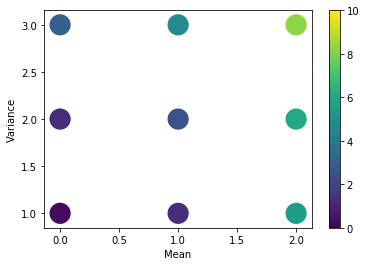

temp/b1
Area under surface (rectangular approx) =  52.924149894920475
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25069517150804954


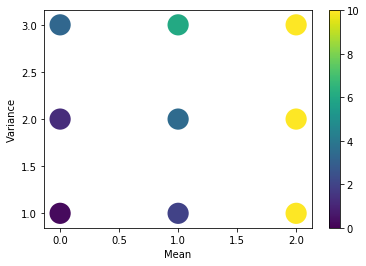

temp/b2
Area under surface (rectangular approx) =  242.10029341449012
Violations =  0.0
Average_violations =  -38294.644958759985
MSE =  0.2561917945771331


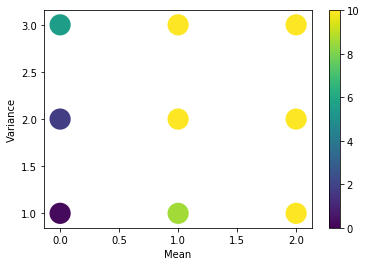

temp/b3
Area under surface (rectangular approx) =  25.54697115748936
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.2515524197137435


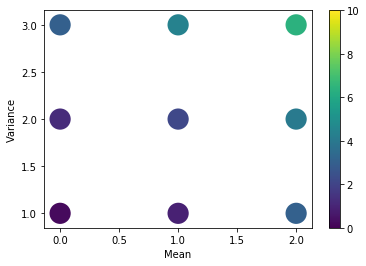

temp/b4
Area under surface (rectangular approx) =  65.77973246358019
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2501156825114976


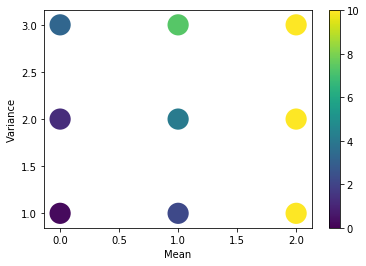

temp/b5
Area under surface (rectangular approx) =  85.85276611086425
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25061440382894473


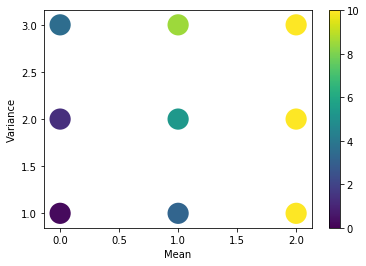

temp/b6
Area under surface (rectangular approx) =  126.30855430979557
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.25165087461235314


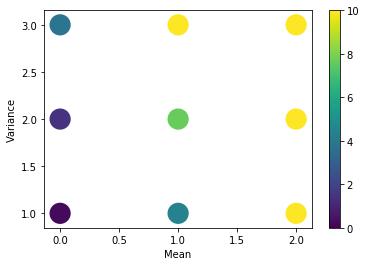

temp/b7
Area under surface (rectangular approx) =  29.76966625077551
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2505709693954908


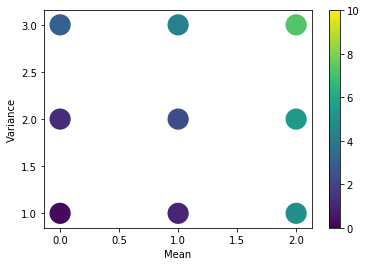

temp/b8
Area under surface (rectangular approx) =  39.252857694482024
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.248793255614799


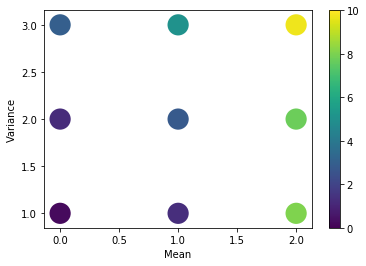

temp/b9
Area under surface (rectangular approx) =  76.81645965246038
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2520030178372803


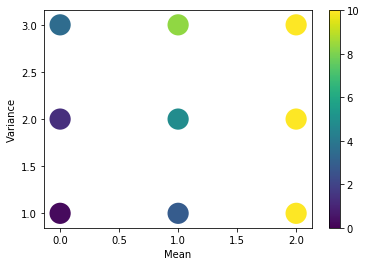

temp/b10
Area under surface (rectangular approx) =  199.30383562942723
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.2565335288746524


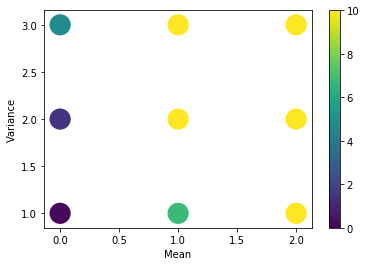

temp/b11
Area under surface (rectangular approx) =  299.9586578079405
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.257022816282701


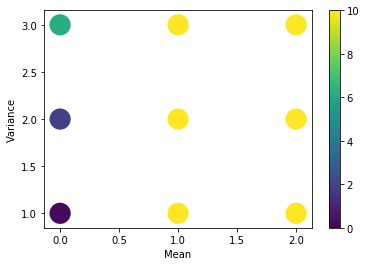

temp/b12
Area under surface (rectangular approx) =  59.255883844127695
Violations =  0.0
Average_violations =  -38291.77790791294
MSE =  0.2555272801771879


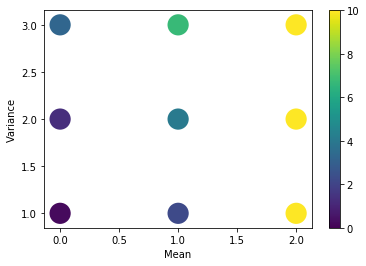

temp/b13
Area under surface (rectangular approx) =  30.088471597304256
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.24758024770887255


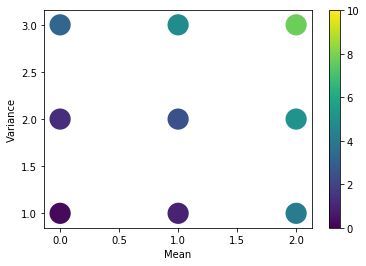

temp/b14
Area under surface (rectangular approx) =  24.336182252317602
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2525393174383545


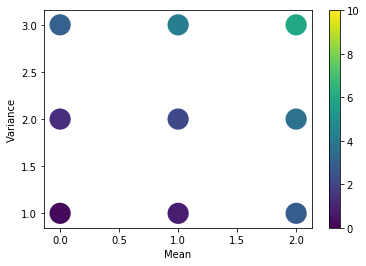

temp/b15
Area under surface (rectangular approx) =  39.566352717683465
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.24975287156210954


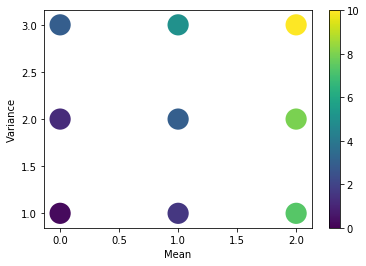

temp/b16
Area under surface (rectangular approx) =  98.00220433073494
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.25308187947997224


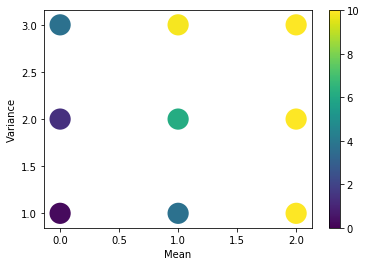

temp/b17
Area under surface (rectangular approx) =  450.0056515564139
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.261619726756487


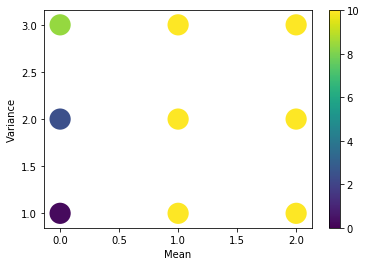

temp/b18
Area under surface (rectangular approx) =  117.19447084425084
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.25952849763981195


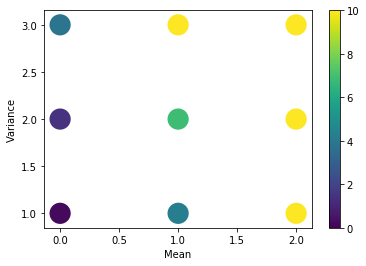

temp/b19
Area under surface (rectangular approx) =  32.437611207569326
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.2512320433887019


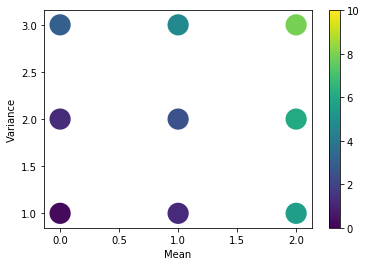

temp/b20
Area under surface (rectangular approx) =  46.121819530172516
Violations =  0.0
Average_violations =  -38294.64495876
MSE =  0.2516412100041203


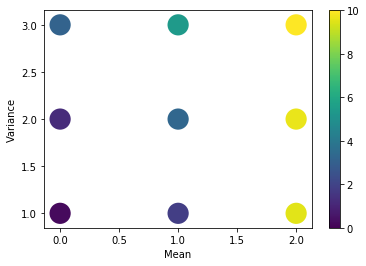

temp/b21
Area under surface (rectangular approx) =  70.60064014947467
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.25552415609691026


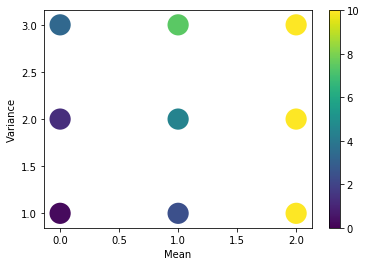

temp/b22
Area under surface (rectangular approx) =  408.1774910962623
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.27062538278223186


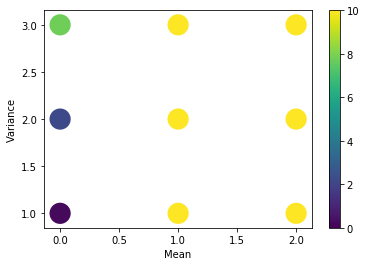

temp/b23
Area under surface (rectangular approx) =  61.14017704047672
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2572951833485558


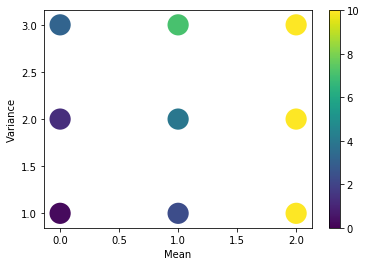

temp/b24
Area under surface (rectangular approx) =  361.7714287777353
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2620632890698528


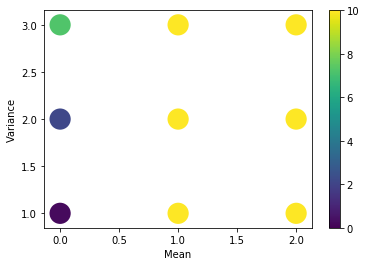

temp/b25
Area under surface (rectangular approx) =  26.101724022886295
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25140964372707536


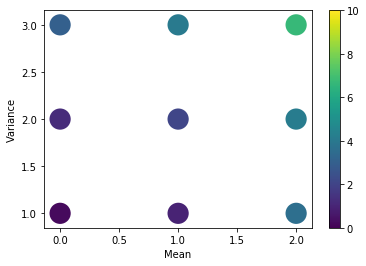

temp/b26
Area under surface (rectangular approx) =  28.25536119115999
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25188020723105514


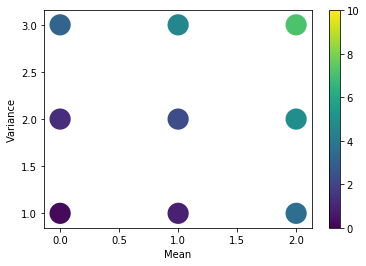

temp/b27
Area under surface (rectangular approx) =  72.8656648338217
Violations =  0.0
Average_violations =  -38294.64495876
MSE =  0.25172486176007464


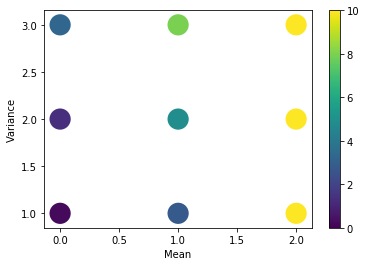

temp/b28
Area under surface (rectangular approx) =  43.80010449834356
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25406643692644865


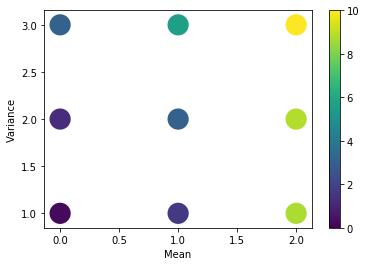

temp/b29
Area under surface (rectangular approx) =  56.097194490082764
Violations =  0.0
Average_violations =  -38294.64495876
MSE =  0.249294521433546


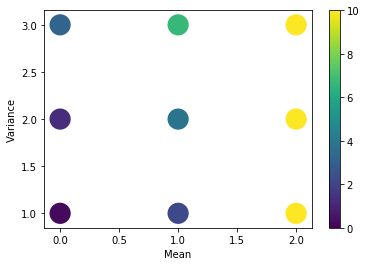

temp/b30
Area under surface (rectangular approx) =  26.395613774739097
Violations =  0.0
Average_violations =  -38294.64495876
MSE =  0.2528965770657202


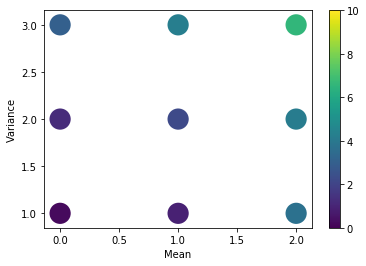

temp/b31
Area under surface (rectangular approx) =  101.78082886330442
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.254478907853702


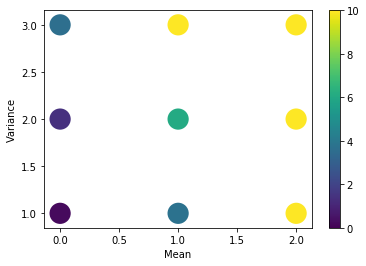

temp/b32
Area under surface (rectangular approx) =  57.032322584633505
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25880931986238914


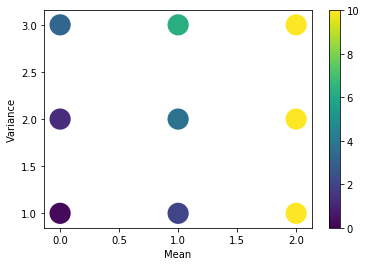

temp/b33
Area under surface (rectangular approx) =  26.748703927089103
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.250432594489343


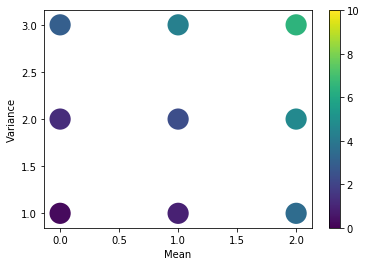

temp/b34
Area under surface (rectangular approx) =  38.13142400249793
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.2486973570979627


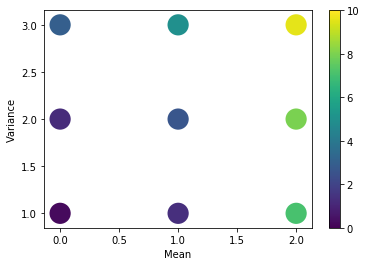

temp/b35
Area under surface (rectangular approx) =  451.33343060554023
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.26965347349248064


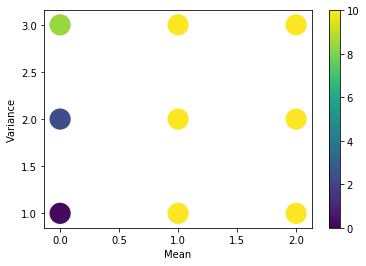

temp/b36
Area under surface (rectangular approx) =  124.13383697368428
Violations =  0.0
Average_violations =  -38297.512009607046
MSE =  0.25356298051281156


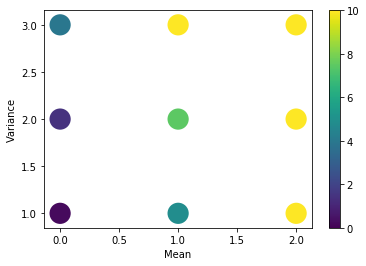

temp/b37
Area under surface (rectangular approx) =  123.71567097784887
Violations =  0.0
Average_violations =  -38300.37906045409
MSE =  0.2522734575186482


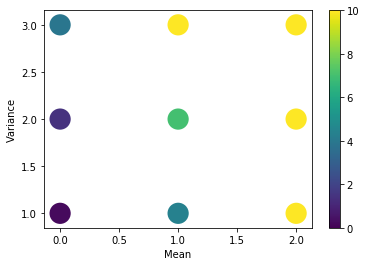

temp/b38
Area under surface (rectangular approx) =  26.141452302542362
Violations =  0.0
Average_violations =  -38294.64512534286
MSE =  0.25057957456359464


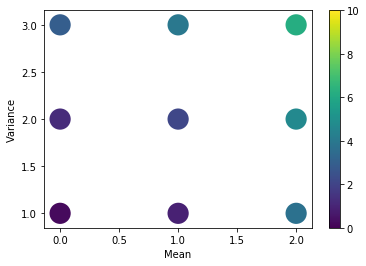

temp/b39
Area under surface (rectangular approx) =  90.64629742626161
Violations =  0.0
Average_violations =  -38294.64512534286
MSE =  0.24935211204203553


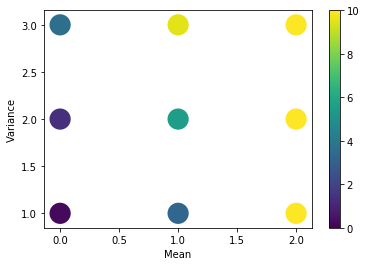

In [21]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

#bar_plot(model_names, 
#         np.array(metric), 
#         np.array(metric_err), 
#         np.array(viol), 
#         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    



-0.13525516704564314


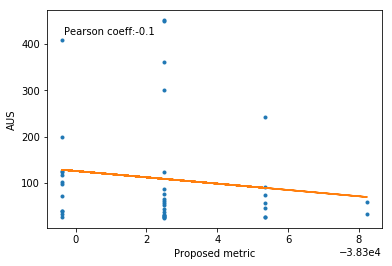

0.8263780214266878


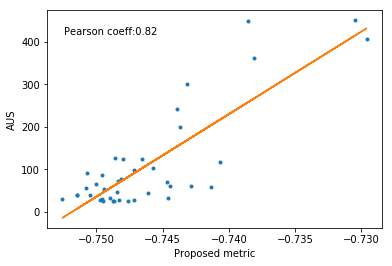

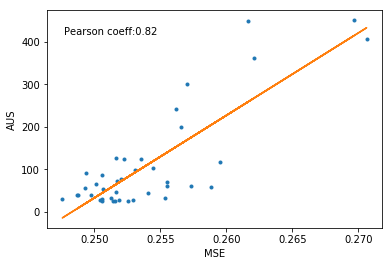

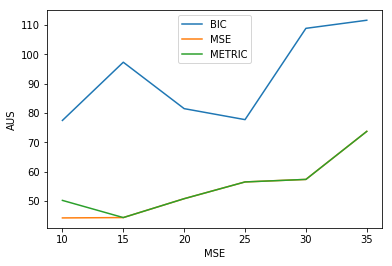

0.8263780214266878

In [22]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]


In [9]:
AUS

[103.29648859854476,
 102.76330897989448,
 263.0147576226347,
 130.96121393477569,
 26.682434710863323,
 55.22909973621877,
 31.83640304912787,
 66.71047557523684,
 70.89177238336391,
 87.97854408033777,
 52.87512874830857,
 117.65616155304977,
 69.85249065596665,
 27.36182955516692,
 245.17770614348476,
 214.00059032589814,
 91.5068277881243,
 45.17254794976009,
 120.04415094801251,
 355.95663294665434,
 45.53443841487837,
 36.23614796151722,
 167.72454882911208,
 35.47123749935777,
 26.139847883295626,
 95.05953074191886,
 76.4930605972476,
 121.29240823529692,
 25.29208990719868,
 30.320747433427627,
 81.53832004185244,
 33.77943896437881,
 41.75745741737471,
 28.052001992200374,
 44.743910513245076,
 111.55903086998028,
 28.31492410179836,
 34.40942644437773,
 407.7522139156233,
 27.851386212417182]